## softmax回归

### 图像分类数据集
1. torchvision.datasets: 一些加载数据的函数及常用的数据集接口；
2. torchvision.models: 包含常用的模型结构（含预训练模型），例如AlexNet、VGG、ResNet等；
3. torchvision.transforms: 常用的图片变换，例如裁剪、旋转等；
4. torchvision.utils: 其他的一些有用的方法。

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import sys
sys.path.append('..')
import d2lzh_pytorch as d2l

In [2]:
mnist_train = torchvision.datasets.FashionMNIST(root='Datasets/FashionMNIST',
                                                train=True,
                                                download=True,
                                                transform=transforms.ToTensor())

mnist_test = torchvision.datasets.FashionMNIST(root='Datasets/FashionMNIST',
                                                train=False,
                                                download=True,
                                                transform=transforms.ToTensor())

d:\anaconda3\envs\pytorch_gpu_1\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
print(type(mnist_train))
print(len(mnist_train), len(mnist_test))

<class 'torchvision.datasets.mnist.FashionMNIST'>
60000 10000


In [4]:
feature, label = mnist_train[0]
print(feature.shape, label)

torch.Size([1, 28, 28]) 9


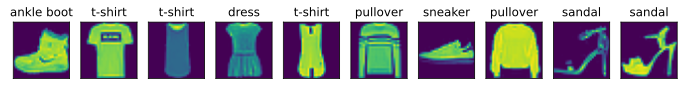

In [5]:
X, y = [], []
for i in range(10):
    X.append(mnist_train[i][0])
    y.append(mnist_train[i][1])
d2l.show_fashion_mnist(X, d2l.get_fashion_mnist_labels(y))

In [7]:
# DataLoader中一个很方便的功能是允许使用多进程来加速数据读取
batch_size = 256
if sys.platform.startswith('win'):
    num_workers = 0 # 0表示不用额外的进程来加速读取数据
else:
    num_workers = 4
train_iter = torch.utils.data.DataLoader(mnist_train,
                                         batch_size=batch_size,
                                         shuffle=True,
                                         num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(mnist_test,
                                        batch_size=batch_size,
                                        shuffle=False,
                                        num_workers=num_workers)

In [8]:
# 训练数据需要的时间
start = time.time()
for X, y in train_iter:
    continue
print('%.2f sec' % (time.time() - start))

4.09 sec


### Softmax回归的手动实现

In [2]:
import torch
import torchvision
import numpy as np
import sys
sys.path.append('..')
import d2lzh_pytorch as d2l

In [3]:
# 【获取和读取数据】
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting C:\Users\54271/Datasets/FashionMNIST\FashionMNIST\raw\train-images-idx3-ubyte.gz to C:\Users\54271/Datasets/FashionMNIST\FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting C:\Users\54271/Datasets/FashionMNIST\FashionMNIST\raw\train-labels-idx1-ubyte.gz to C:\Users\54271/Datasets/FashionMNIST\FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting C:\Users\54271/Datasets/FashionMNIST\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to C:\Users\54271/Datasets/FashionMNIST\FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting C:\Users\54271/Datasets/FashionMNIST\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to C:\Users\54271/Datasets/FashionMNIST\FashionMNIST\raw



d:\anaconda3\envs\pytorch_gpu_1\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
# 【初始化模型参数】
num_inputs = 784
num_outputs = 10

W = torch.tensor(np.random.normal(0, 0.01, (num_inputs, num_outputs)), dtype=torch.float)
b = torch.zeros(num_outputs, dtype=torch.float)

In [5]:
W.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [6]:
# 【实现softmax运算】
X = torch.tensor([[1,2,3], [4,5,6]])
# 可以只对其中同一列（dim=0）或同一行（dim=1）的元素求和，并在结果中保留行和列这两个维度（keepdim=True）
print(X.sum(dim=0, keepdim=True))
print(X.sum(dim=1, keepdim=True))

tensor([[5, 7, 9]])
tensor([[ 6],
        [15]])


In [7]:
# 矩阵X的行数是样本数，列数是输出个数
def softmax(X):
    # 为了表达样本预测各个输出的概率，softmax运算会先通过exp函数对每个元素做指数运算，再对exp矩阵同行元素求和，最后令矩阵每行各元素与该行元素之和相除
    X_exp = X.exp()
    partition = X_exp.sum(dim=1, keepdims=True)
    return X_exp / partition # 广播机制
# 这样一来，最终得到的矩阵每行元素和为1且非负。因此，该矩阵每行都是合法的概率分布。softmax运算的输出矩阵中的任意一行元素代表了一个样本在各个输出类别上的预测概率。

In [8]:
X = torch.rand((2,5))
X_prob = softmax(X)
print(X_prob, X_prob.sum(dim=1))

tensor([[0.2150, 0.2449, 0.1906, 0.1469, 0.2025],
        [0.1554, 0.3045, 0.1640, 0.1598, 0.2163]]) tensor([1.0000, 1.0000])


In [9]:
# 【定义模型】
def net(X):
    return softmax(torch.mm(X.view((-1, num_inputs)), W) + b)

In [12]:
# 【定义损失函数】
y_hat = torch.tensor([[0.1,0.3,0.6], [0.3,0.2,0.5]])
y = torch.LongTensor([0, 2])
y_hat.gather(1, y.view(-1, 1))

tensor([[0.1000],
        [0.5000]])

In [13]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat.gather(1, y.view(-1,1)))

In [14]:
# 【计算分类准确率】
def accuracy(y_hat, y):
    return (y_hat.argmax(dim=1) ==y).float().mean().item()

In [15]:
print(accuracy(y_hat, y))

0.5


In [16]:
print(d2l.evaluate_accuracy(test_iter, net))

0.1301


In [17]:
num_epochs, lr = 5, 0.1
d2l.train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, batch_size, [W, b], lr)

epoch 1, loss 0.7888, train acc 0.746, test acc 0.789
epoch 2, loss 0.5713, train acc 0.813, test acc 0.809
epoch 3, loss 0.5270, train acc 0.825, test acc 0.816
epoch 4, loss 0.5023, train acc 0.832, test acc 0.816
epoch 5, loss 0.4858, train acc 0.835, test acc 0.827


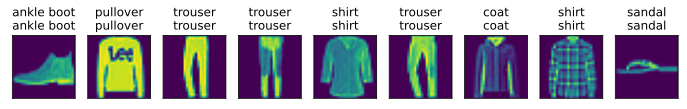

In [18]:
# 【预测】
X, y = iter(test_iter).next()

true_labels = d2l.get_fashion_mnist_labels(y.numpy())
pred_labels = d2l.get_fashion_mnist_labels(net(X).argmax(dim=1).numpy())
titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]

d2l.show_fashion_mnist(X[0:9], titles[0:9])

### Softmax 调库实现

In [20]:
import torch
from torch import nn
from torch.nn import init
import numpy as np
import sys
sys.path.append("..")
import d2lzh_pytorch as d2l

In [21]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [22]:
num_inputs = 784
num_outputs = 10

class LinearNet(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(LinearNet, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)
    def forward(self, x):
        y = self.linear(x.view(x.shape[0], -1))
        return y
net = LinearNet(num_inputs, num_outputs)

In [23]:
from collections import OrderedDict
net = nn.Sequential(
    OrderedDict([
        ('flatten', d2l.FlattenLayer()), # x的形状转换的这个功能
        ('linear', nn.Linear(num_inputs, num_outputs))
    ])
)

In [24]:
# 使用均值为0、标准差为0.01的正态分布随机初始化模型的权重参数
init.normal_(net.linear.weight, mean=0, std=0.01)
init.constant(net.linear.bias, val=0)

C:\Users\54271\AppData\Local\Temp/ipykernel_3764/2256232023.py:2: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(net.linear.bias, val=0)


Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [25]:
loss = nn.CrossEntropyLoss()

In [26]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)

In [27]:
num_epochs = 5
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, optimizer)

epoch 1, loss 0.0031, train acc 0.749, test acc 0.782
epoch 2, loss 0.0022, train acc 0.814, test acc 0.809
epoch 3, loss 0.0021, train acc 0.825, test acc 0.818
epoch 4, loss 0.0020, train acc 0.833, test acc 0.810
epoch 5, loss 0.0019, train acc 0.837, test acc 0.823


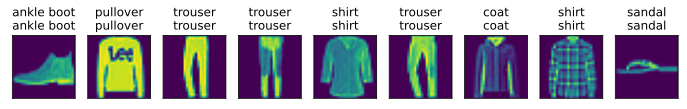

In [28]:
X, y = iter(test_iter).next()

true_labels = d2l.get_fashion_mnist_labels(y.numpy())
pred_labels = d2l.get_fashion_mnist_labels(net(X).argmax(dim=1).numpy())
titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]

d2l.show_fashion_mnist(X[0:9], titles[0:9])

In [31]:
v = torch.tensor([[1,2,3],[4,5,6]])
v

tensor([[1, 2, 3],
        [4, 5, 6]])

In [37]:
v_exp = v.exp()
v_exp

tensor([[  2.7183,   7.3891,  20.0855],
        [ 54.5981, 148.4132, 403.4288]])

In [36]:
v_exp.sum()

tensor(636.6329)

In [41]:
v_exp.sum(dim=1) # 行内相加

tensor([ 30.1929, 606.4401])

In [44]:
p = v_exp.sum(dim=1, keepdims=True) # 保持维度
p

tensor([[ 30.1929],
        [606.4401]])

In [43]:
v_exp / p

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])